In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from BlackScholesBarenblatt100D import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([100.0, 50.0] * int(D / 2))[None, :]
T = 1.0

"Available architectures"
mode = "FC"  # FC, Resnet and NAIS-Net are available
activation = "ReLU"  # Sine and ReLU are available
model = BlackScholesBarenblatt(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-3

In [4]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
Gradients at iteration 0:
 - layer1.weight grad norm: 0.5133111476898193
 - layer1.bias grad norm: 0.00059798255097121
 - layer2.weight grad norm: 0.0019682368729263544
 - layer2.bias grad norm: 0.0005891931941732764
 - layer2_input.weight grad norm: 0.5077073574066162
 - layer2_input.bias grad norm: 0.0005891931941732764
 - layer3.weight grad norm: 0.002669684123247862
 - layer3.bias grad norm: 0.0005741642671637237
 - layer3_input.weight grad norm: 0.494527667760849
 - layer3_input.bias grad norm: 0.0005741642671637237
 - layer4.weight grad norm: 0.0032641850411891937
 - layer4.bias grad norm: 0.0005633259424939752
 - layer4_input.weight grad norm: 0.4837028980255127
 - layer4_input.bias grad norm: 0.0005633259424939752
 - layer5.weight grad norm: 0.012796120718121529
 - layer5.bias grad norm: 0.005568892229348421
It: 0, Loss: 5.280e+13, Y0: 1.412, Time: 0.42, Learning Rate: 1.000e-03
Gradients at iteration 1:
 - layer1.weight grad norm: 0.527459442615509
 - layer1.bias grad n

KeyboardInterrupt: 

In [5]:
np.random.seed(42)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)
samples = 5

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

Y_test = np.reshape(u_exact(T,np.reshape(t_test[0:M, :, :], [-1, 1]), np.reshape(X_pred[0:M, :, :], [-1, D])),
                    [M, -1, 1])

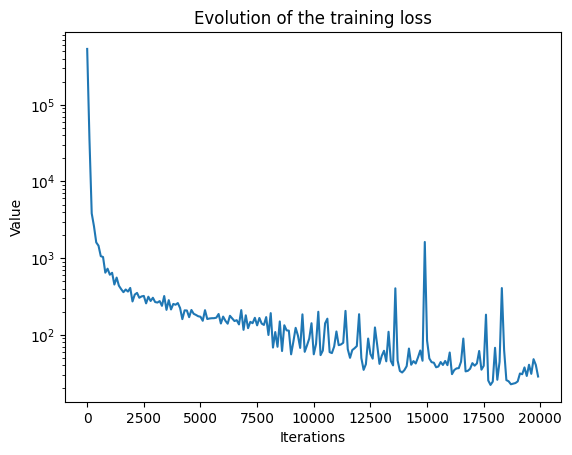

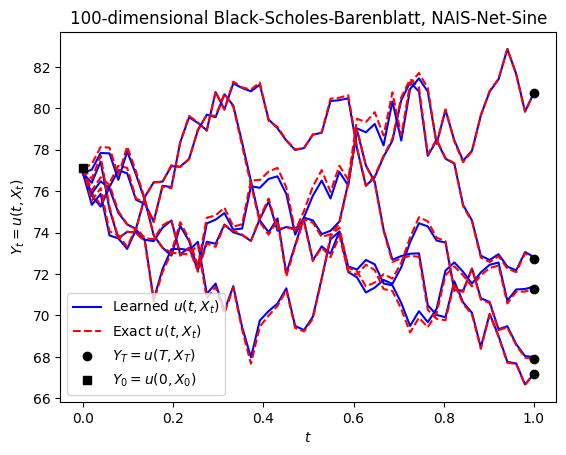

In [6]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')

plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')

plt.plot([0], Y_test[0, 0, 0], 'ks', label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

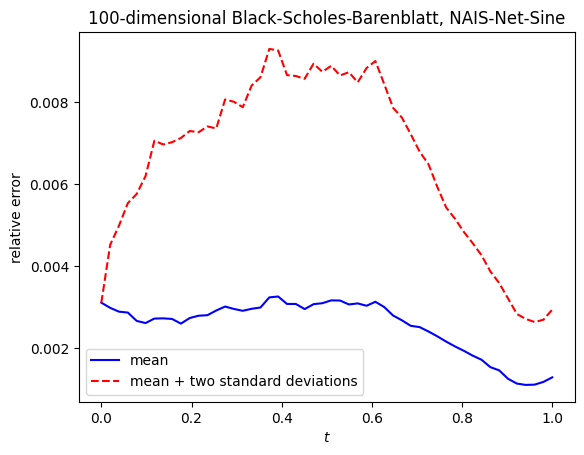

In [7]:
errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)

plt.figure()
plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
plt.show()

In [8]:
model.save_model("models/BlackScholesBarenblattMLMC100D.pth")